# NYC Taxi data

## Import cuxfilter

In [ ]:
import cuxfilter
from bokeh import palettes
from cuxfilter.layouts import double_feature

import cudf

In [ ]:
#update data_dir if you have downloaded datasets elsewhere
DATA_DIR = './data'

## Download required datasets

In [ ]:
! curl https://rapidsai-data.s3.us-east-2.amazonaws.com/viz-data/nyc_taxi.tar.gz --create-dirs -o $DATA_DIR/nyc_taxi.tar.gz

In [ ]:
from cuxfilter.sampledata import datasets_check
datasets_check('nyc_taxi', base_dir=DATA_DIR)

## preprocess the data

In [ ]:
cudf_df = cudf.read_csv(DATA_DIR + '/nyc_taxi.csv')

from pyproj import Proj, Transformer

# Apply transformation
transform_4326_to_3857 = Transformer.from_crs('epsg:4326', 'epsg:3857')
cudf_df['dropoff_x'], cudf_df['dropoff_y'] = transform_4326_to_3857.transform(
                                                cudf_df['dropoff_latitude'].to_array(), cudf_df['dropoff_longitude'].to_array()
                                            )

cudf_df = cudf_df.drop(['dropoff_latitude', 'dropoff_longitude'], axis=1)
cudf_df = cudf_df.dropna(axis=0)

# Filter over Manhattan
cudf_df = cudf_df[
    (cudf_df.dropoff_x > -8239910.23) & (cudf_df.dropoff_x < -8229529.24) & (cudf_df.dropoff_y > 4968481.34) & (cudf_df.dropoff_y < 4983152.92)
]

cudf_df.head()

## Read the dataset

In [ ]:
cux_df = cuxfilter.DataFrame.from_dataframe(cudf_df)

## Define charts

In [ ]:
from bokeh.tile_providers import get_provider as gp
tile_provider = gp('CARTODBPOSITRON')

> Uncomment the below lines and replace MAPBOX_TOKEN with mapbox token string if you want to use mapbox map-tiles. Can be created for free here -https://www.mapbox.com/help/define-access-token/

In [ ]:
#from cuxfilter.assets.custom_tiles import get_provider, Vendors
#tile_provider = get_provider(Vendors.MAPBOX_LIGHT, access_token=MAPBOX_TOKEN)

In [ ]:
chart1 = cuxfilter.charts.scatter(x='dropoff_x',
                                 y='dropoff_y',
                                 aggregate_fn='mean',aggregate_col='payment_type', pixel_shade_type='log', legend_position='center',
                                 tile_provider=tile_provider, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92))

chart2 = cuxfilter.charts.bar('passenger_count', data_points=9)

## Create a dashboard object

In [ ]:
d = cux_df.dashboard([chart1, chart2], layout=double_feature, theme=cuxfilter.themes.dark, title= 'NYC TAXI DATASET')

In [12]:
#dashboard object
d

#### cuxfilter DashBoard
    
    [title] (Markdown(str), [])
    [chart1] (Column(sizing_mode='scale_both', width=900)
    [0] Bokeh(Figure), [])
    [chart2] (Column(sizing_mode='scale_both', width=900)
    [0] Bokeh(Figure)
    [1] RangeSlider(end=9, sizing_mode='scale_width', step=1, value=(0, 9), width=900), [])
    [widgets] (Column
    [0] Column(css_classes=['non-handle-temp'], sizing_mode='scale_both')
        [0] FloatSlider(bar_color='#8735fb', end=11075631, name='Data Points selected', sizing_mode='scale_both', value=11075631, width=280), [])

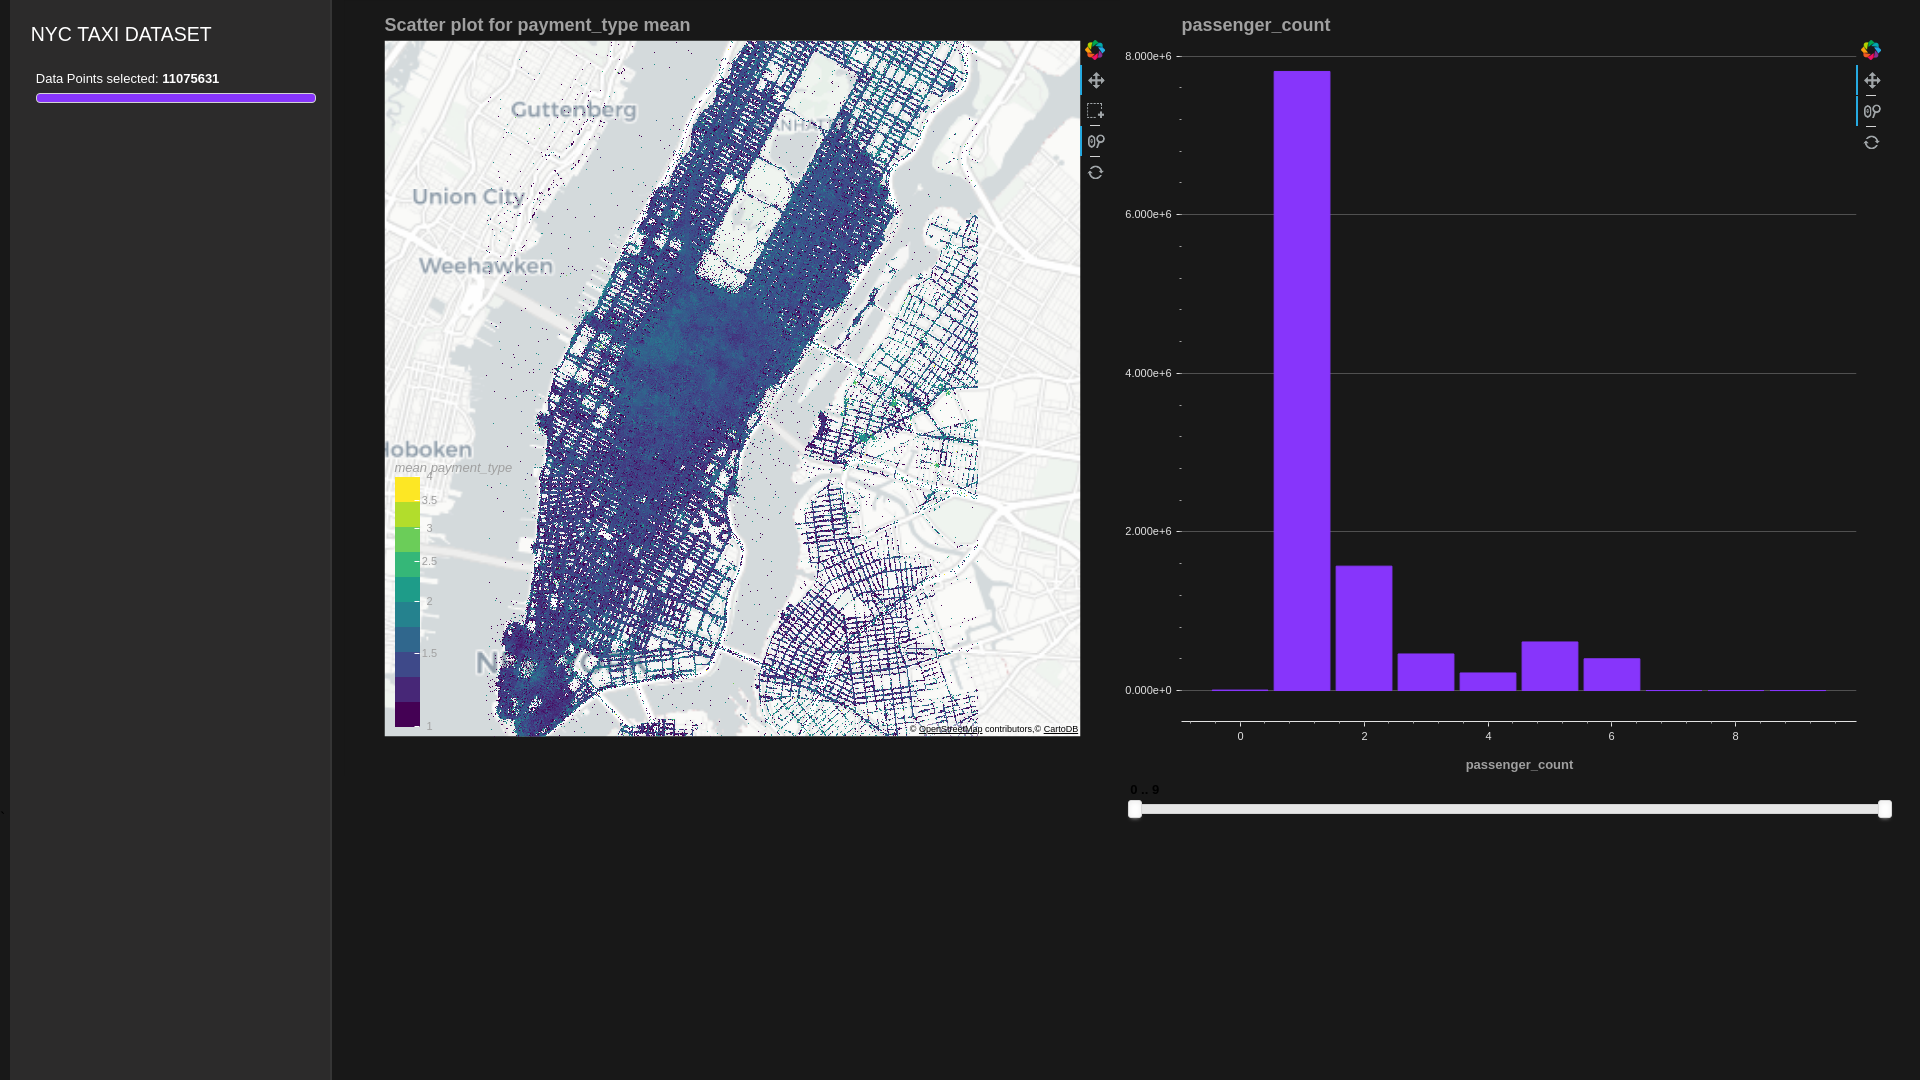

In [13]:
#execute below line for dashboard preview
# await d.preview()

## Starting the dashboard

1. d.show('current_notebook_url:current_notebook_port') remote dashboard

2. d.app('current_notebook_url:current_notebook_port') inline in notebook (layout is ignored, and charts are displayed one below another)

Incase you need to stop the server:

- d.stop()

In [ ]:
# d.show(notebook_url='')

## Export the queried data into a dataframe

In [ ]:
queried_df = d.export()